In [1]:
# Importing the relevant libraries
import IPython.display
import json
import ray
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
# import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template
import datetime
from datetime import timedelta

In [38]:
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

items = pd.read_csv("inputs/items.csv")
holiday_events = pd.read_csv("inputs/holidays_events.csv")
stores = pd.read_csv("inputs/stores.csv")
oil = pd.read_csv("inputs/oil.csv")
transactions = pd.read_csv("inputs/transactions.csv")
# Read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
pd_train = pd.read_csv("inputs/train.csv", parse_dates=["date"] , dtype=dtypes)

In [40]:
pd_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [ ]:
#add missing date
min_oil_date = min(pd_train['date'])
max_oil_date = max(pd_train['date'])

calendar = []

d1 = min_oil_date
d2 = max_oil_date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [ ]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type
print('Type : ', '\n', oil.dtypes)

#Print the 3 first line
oil.head(5)

In [ ]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2   

In [ ]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

In [ ]:
# Change object date column to datetime so the merge works
holiday_events['date'] = pd.to_datetime(holiday_events['date'], format="%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format="%Y-%m-%d")
holiday_events.dtypes

In [ ]:
#Merge train
pd_train = pd_train.drop('id', axis = 1)
pd_train = pd_train.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
pd_train = pd_train.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
pd_train = pd_train.merge(holiday_events, left_on='date', right_on='date', how='left')
pd_train = pd_train.merge(oil, left_on='date', right_on='date', how='left')
pd_train = pd_train.drop(['description', 'locale_name'], axis = 1)

In [34]:
df = pd.read_csv("train_merged.csv")

In [35]:
df.head()

,Unnamed: 0,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type_x,cluster,family,class,perishable,type_y,locale,transferred,dcoilwtico
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,Holiday,National,False,93.14
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,Holiday,National,False,93.14
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,Holiday,National,False,93.14
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1030,0,Holiday,National,False,93.14
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1,DELI,2644,1,Holiday,National,False,93.14


In [36]:
confuse_df = df = df.drop(['date', "store_nbr", "dcoilwtico",  "onpromotion", "type_x", "class", "item_nbr", "Unnamed: 0", "state", "city"], axis=1)

In [37]:
confuse_df = pd.get_dummies(confuse_df)

In [38]:
confuse_df.head()

,unit_sales,cluster,perishable,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGES,family_BREAD/BAKERY,family_CLEANING,family_DAIRY,family_DELI,...,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MEATS,family_PERSONAL CARE,family_POULTRY,family_PREPARED FOODS,family_SEAFOOD,type_y_Holiday,locale_National,transferred_False
0,7.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,2.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1.0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1


In [39]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

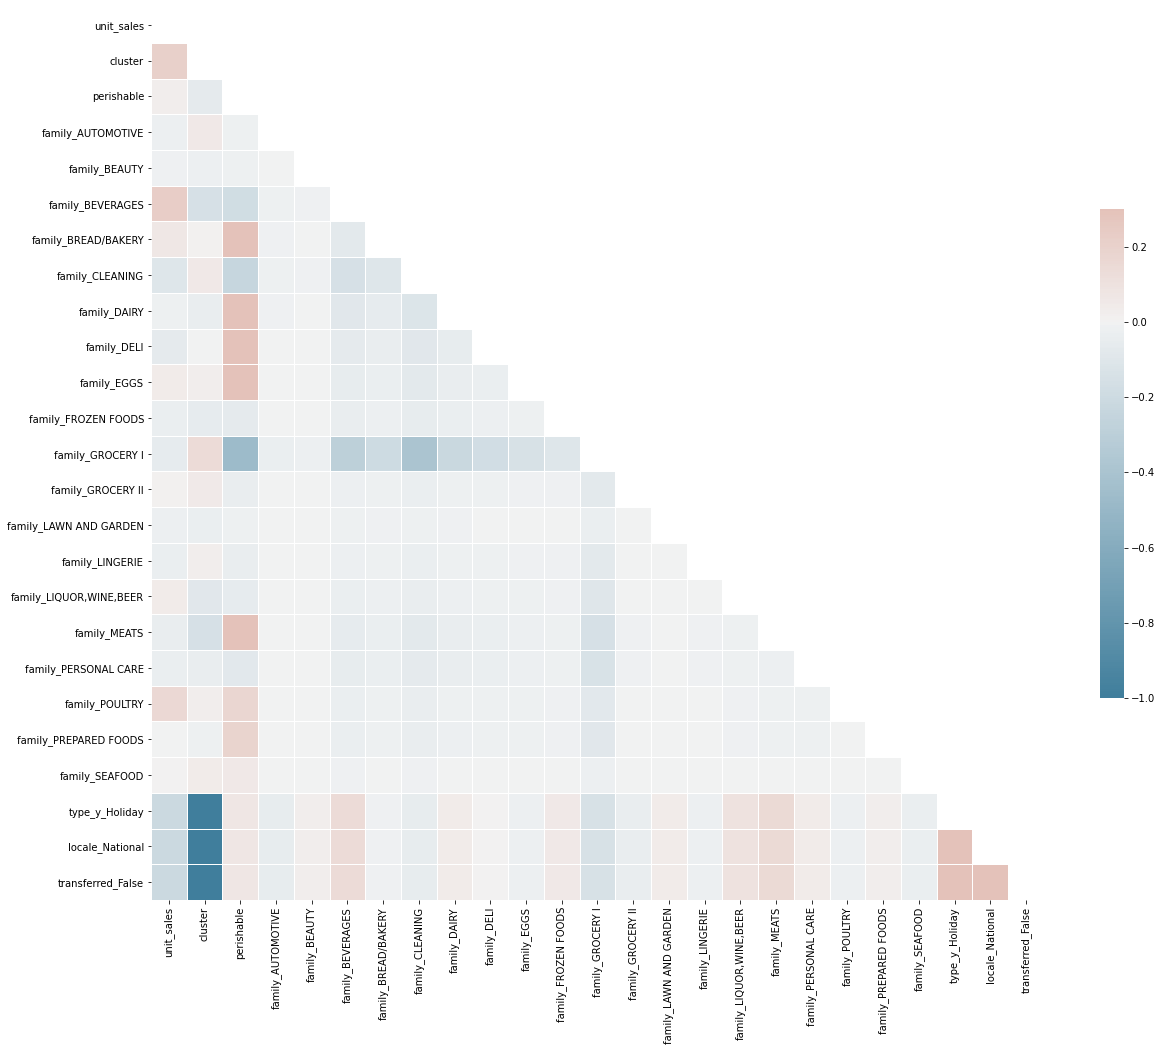

In [40]:
# Compute the correlation matrix
corr = confuse_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})